# Example of using VaDEGam model

## 1. Setup

### 1.1 Install requirements

In [1]:
# %pip install --upgrade pymc3
# %pip install numpy==1.23.5
# %pip install scipy==1.14.1
# %pip install tensorflow==2.17.0 keras==3.5.0
# %pip install kagglehub
# %pip install scikit-learn==1.5.2
# %pip install seaborn==0.13.2

In [1]:
from VADEGAM import *
from VADEGAM_pipeline import *
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import scipy as sc
from model_args import getArgs 

from sklearn.model_selection import train_test_split

# import kagglehub


In [2]:
args = getArgs([])
args

Namespace(seed=12345, batch_size=100, epochs=5000, latent_dim=3, num_clusters=15, gamma=1, classify=True, num_output_head=3, num_classes=2, validation_frac=0.2, imputation_strategy='MICE', iqr_scaler=1.5, data_path='./test_data', results_path='./results', use_early_stopping=True, early_stopping_patience=50, learning_rate=0.001, use_lr_schedule=True, s_to_classifier=False, learn_prior=True, final_activation='softmax', c_sigma_initializer='glorot', nn_layers=[64, 32, 16])

In [3]:
data_path = args.data_path

# heartdata = pd.read_csv(data_path + '/heart_attack_risk_dataset.csv')
heartdata = pd.read_csv(data_path + '/wine-clustering.csv')
heartdata.head()

,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [6]:
# heartdata['Female'] = pd.get_dummies(heartdata['Gender'])['Female']
# heartdata = heartdata.drop(columns = ['Gender'])


In [7]:
# y_data = heartdata['Heart_Attack_Risk']
# X_data = heartdata[[col for col in heartdata.columns if col !='Heart_Attack_Risk']]

In [8]:
# X_train, X_test, y_train, y_test  = train_test_split(X_data, y_data.values.reshape(-1,1), stratify=y_data)
X_train, X_test = train_test_split(heartdata)

In [12]:
args.num_output_head=1
# args.num_classes = len(np.unique(y_train))
args.latent_dim = 2
args.num_clusters = 10
args.learn_prior = True
args.classify = False
args.nn_layers = [40, None, None]
args.c_sigma_initializer = 'constant'

In [13]:
preprocessor = PREPROCESSOR_WRAPPER(args)
preprocessor.build(X_train)
# train_generator, val_generator, train_data, val_data = preprocessor.data_pipeline(X_train, y_train, return_generator=True)
train_generator, val_generator, train_data, val_data = preprocessor.data_pipeline(X_train, None, return_generator=True)

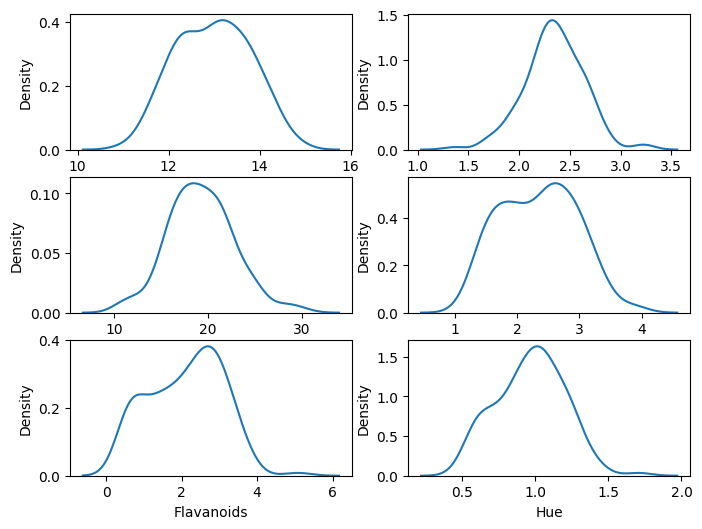

In [14]:
fig, axes = plt.subplots(3, 2, figsize=(8,6))
axes = axes.flatten()
for ax, feat in zip(axes, preprocessor.cont_features):
    sns.kdeplot(ax=ax, data=X_train, x=feat)
    
plt.show()

In [15]:
vadegam = VADEGAM_WRAPPER(args, preprocessor.cont_dim, preprocessor.bin_dim)
vadegam.build()
history = vadegam.model_fit(train_generator, val_generator)

c:\Users\Elissa\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\optimizers\base_optimizer.py:678: UserWarning: Gradients do not exist for variables ['kernel', 'bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


Epoch 1: gmm_loss=1.0449, negloglik_bin=0.0000, negloglik_cont=12.6479, recon_loss=12.6479, total_loss=13.6929, val_gmm_loss=0.4100, val_negloglik_bin=0.0000, val_negloglik_cont=12.7705, val_recon_loss=12.7705, val_total_loss=13.1805, learning_rate=0.0010
Epoch 50: gmm_loss=0.2028, negloglik_bin=0.0000, negloglik_cont=10.5517, recon_loss=10.5517, total_loss=10.7545, val_gmm_loss=0.2197, val_negloglik_bin=0.0000, val_negloglik_cont=11.0184, val_recon_loss=11.0184, val_total_loss=11.2381, learning_rate=0.0010
Epoch 100: gmm_loss=0.2061, negloglik_bin=0.0000, negloglik_cont=8.7339, recon_loss=8.7339, total_loss=8.9400, val_gmm_loss=0.8427, val_negloglik_bin=0.0000, val_negloglik_cont=9.2081, val_recon_loss=9.2081, val_total_loss=10.0508, learning_rate=0.0010
Epoch 150: gmm_loss=1.0975, negloglik_bin=0.0000, negloglik_cont=5.5032, recon_loss=5.5032, total_loss=6.6007, val_gmm_loss=0.7985, val_negloglik_bin=0.0000, val_negloglik_cont=6.1772, val_recon_loss=6.1772, val_total_loss=6.9757, lea

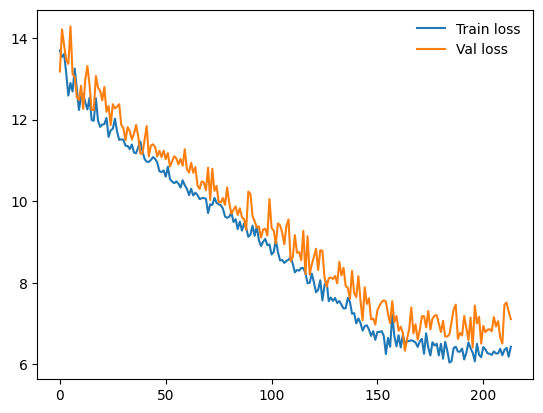

In [16]:
plt.plot(history.epoch, history.history['total_loss'], label='Train loss')
plt.plot(history.epoch, history.history['val_total_loss'], label='Val loss')
plt.legend(frameon=False)
plt.show()

In [17]:
X_all = pd.concat([train_data[0], val_data[0]], axis=0).loc[X_train.index].reset_index(drop=True)
X_all

,Alcohol,Ash,Ash_Alcanity,Total_Phenols,Flavanoids,Hue,OD280,Malic_Acid,Magnesium,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Proline
0,0.779588,1.386207,-0.690247,0.882772,0.977866,1.401892,0.382757,-0.345049,1.077156,-0.336349,-0.087135,1.011547,1.628486
1,-0.229974,0.236633,1.589494,-1.857546,-1.002479,-1.283697,-1.813462,0.210989,-0.013863,-0.633547,-1.708760,0.457506,-0.458219
2,-0.180727,0.926377,0.918982,-1.051570,-1.535649,-0.374062,-0.729801,1.003243,0.627290,1.618863,-1.290961,0.409858,-0.414760
3,0.693406,0.466547,0.416098,1.060086,0.836413,0.102414,0.599489,-0.448099,1.363870,-1.480075,1.399209,0.663787,1.243729
4,1.518291,0.351590,-1.226656,0.802174,1.141081,0.362309,1.885433,-0.474606,2.104092,-0.530963,1.205291,0.433809,1.120091
...,...,...,...,...,...,...,...,...,...,...,...,...,...
128,-1.017924,0.734781,-0.086786,-0.664702,-0.284332,2.138263,-0.556415,-0.850578,0.471657,0.807377,-1.088875,-1.017485,-1.577434
129,0.139378,-2.445707,-1.427810,1.092325,1.271654,0.708837,0.816221,-1.674907,-1.878850,-0.740004,1.192725,0.294570,-0.726683
130,-0.784001,0.159994,0.583726,-0.003802,-1.187456,-1.716856,-1.495588,1.363588,-0.893259,1.104575,-1.061133,1.116420,-0.640183
131,0.287119,-0.223197,-0.254414,-0.809778,-1.285385,-1.716856,-1.596730,1.024061,-0.013863,1.665489,0.623523,1.829824,0.000389


In [18]:
z_mean, z_logvar, z = vadegam.vadegam.encoder(X_all)
clusters = vadegam.vadegam.get_clusters(z_mean)
x_mean_pred, x_logvar_pred, theta_pred = vadegam.vadegam.decoder(z_mean)
reconstructed = tf.concat([x_mean_pred, theta_pred], axis=1)

In [20]:
np.unique(clusters, return_counts=True)


(array([1, 3, 5, 7, 8], dtype=int64), array([ 6, 49, 34, 13, 31], dtype=int64))

In [21]:
clust_probs = vadegam.vadegam.get_clusters(z_mean, probs=True)

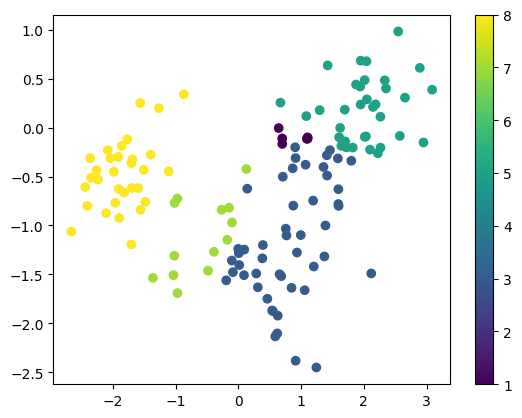

In [24]:
plt.scatter(z_mean[:,0], z_mean[:,1], c=clusters)
plt.colorbar()
plt.show()

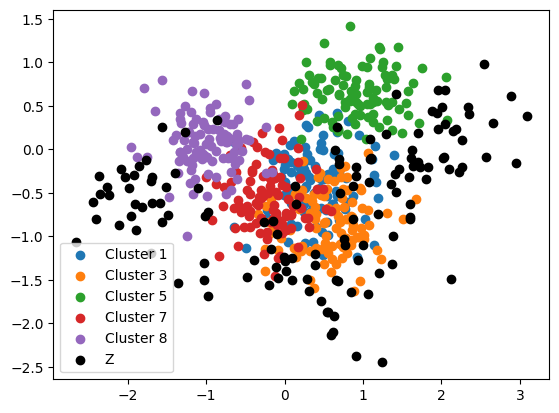

In [27]:
    
# fig, axes = plt.subplots(ncols=3, figsize=(10,6))
# axes = axes.flatten()
for i in range(args.num_clusters):
    if i in np.unique(clusters):
        cluster_samples = np.random.multivariate_normal(vadegam.vadegam.c_mu[i,:].numpy(), np.diag(vadegam.vadegam.log_c_sigma[i,:]), size = 100)

        plt.scatter(cluster_samples[:,0],cluster_samples[:,1], label = f'Cluster {i}')
plt.scatter(z_mean[:,0], z_mean[:,1], color='black', label='Z')
plt.legend()
plt.show()